# **PneumoScan**

---



## Setup

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set Dataset Directory
import os
DATA_DIR = '/content/drive/MyDrive/chest_xray'

# Check if path exists
os.listdir(DATA_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['.DS_Store', 'test', 'train', 'val']

In [ ]:
!pip install tensorflow
!pip install keras
!pip install matplotlib seaborn


## EDA & Data Preprocessing

### Basic Imports & Data Overview

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


### Dataset Paths

In [ ]:
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')


### Class Distribution Check

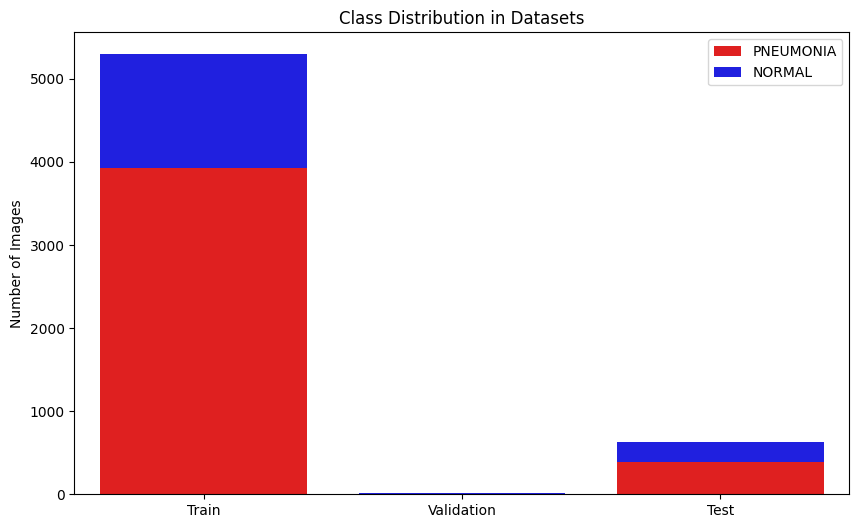

In [ ]:
def count_images(directory):
    pneumonia_count = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    normal_count = len(os.listdir(os.path.join(directory, 'NORMAL')))
    return pneumonia_count, normal_count

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

datasets = ['Train', 'Validation', 'Test']
pneumonia = [train_counts[0], val_counts[0], test_counts[0]]
normal = [train_counts[1], val_counts[1], test_counts[1]]

# Plot distribution
plt.figure(figsize=(10,6))
sns.barplot(x=datasets, y=pneumonia, color='red', label='PNEUMONIA')
sns.barplot(x=datasets, y=normal, bottom=pneumonia, color='blue', label='NORMAL')
plt.legend()
plt.title('Class Distribution in Datasets')
plt.ylabel('Number of Images')
plt.show()


### Image Data Generators (Data Augmentation)

In [ ]:
IMG_SIZE = 224  # We can go 299 if using InceptionV3

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5293 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Verify Some Samples

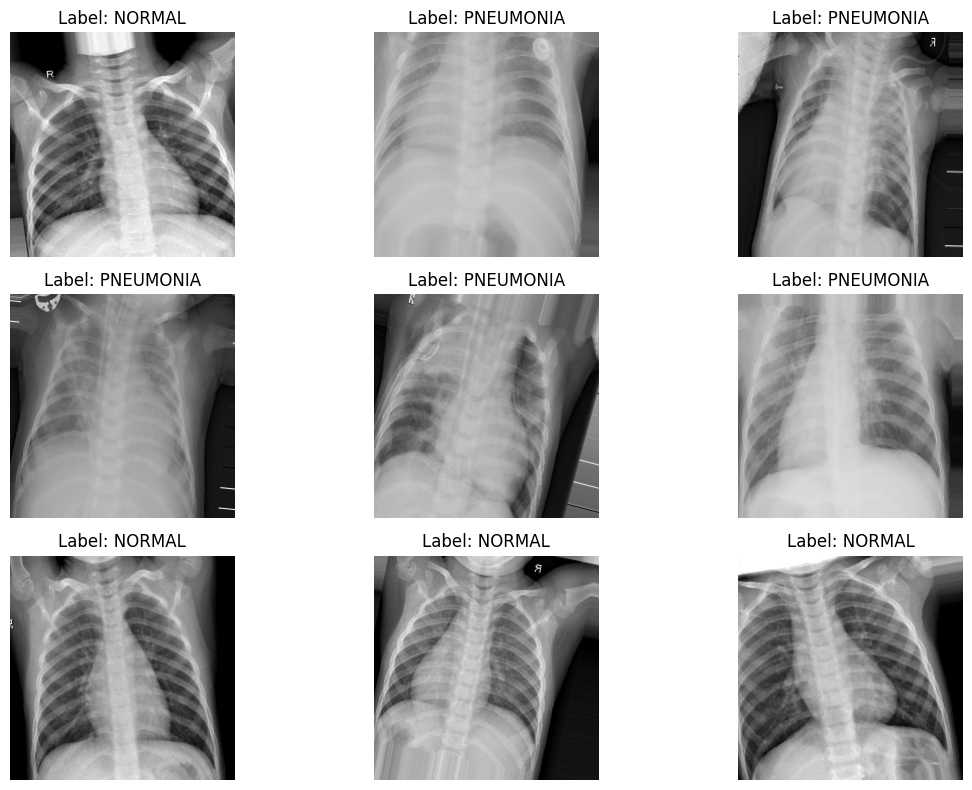

In [ ]:
# Display some augmented training images
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Label: ' + ('PNEUMONIA' if sample_labels[i] else 'NORMAL'))
    plt.axis('off')
plt.tight_layout()
plt.show()


## EfficientNetB0 Model Building & Training


---



### Imports

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Build the Model

In [ ]:
IMG_SIZE = 224  # EfficientNetB0 works well with 224x224

# Load EfficientNetB0 without the top classification layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer (binary classification)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Model Architecture

In [ ]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 224, 224, 3)    │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,219,300 (16.10 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 4,052,387 (15.46 MB)

### Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('EfficientNetB0_Pneumonia.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)


### Train the Model

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.5199 - loss: 0.8502
Epoch 1: val_loss improved from inf to 0.80999, saving model to EfficientNetB0_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 201s 806ms/step - accuracy: 0.5199 - loss: 0.8500 - val_accuracy: 0.5000 - val_loss: 0.8100
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.5502 - loss: 0.7698
Epoch 2: val_loss did not improve from 0.80999
166/166 ━━━━━━━━━━━━━━━━━━━━ 116s 696ms/step - accuracy: 0.5503 - loss: 0.7697 - val_accuracy: 0.5000 - val_loss: 0.9986
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.5796 - loss: 0.7329
Epoch 3: val_loss did not improve from 0.80999
166/166 ━━━━━━━━━━━━━━━━━━━━ 115s 693ms/step - accuracy: 0.5797 - loss: 0.7329 - val_accuracy: 0.5000 - val_loss: 1.0180
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.6227 - loss: 0.6987
Epoch 4: val_loss did not improve from 0.80999
166/166 ━━━━━━━━━━━━━━━━━━━━ 114s 687ms/step - accuracy: 0.6227 - loss: 0.6987 - val_accuracy: 0.5000 - val_loss: 1.0318
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.6413 - loss: 0.6895
Epoch 5: val_loss did n

### Fine-Tuning

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Re-compile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continue training
fine_tune_history = model.fit(
    train_generator,
    epochs=10,  # Fine-tune for a few epochs
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.6060 - loss: 0.7270
Epoch 1: val_loss did not improve from 0.80999
166/166 ━━━━━━━━━━━━━━━━━━━━ 247s 979ms/step - accuracy: 0.6064 - loss: 0.7264 - val_accuracy: 0.5000 - val_loss: 0.8496
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.7901 - loss: 0.4647
Epoch 2: val_loss did not improve from 0.80999
166/166 ━━━━━━━━━━━━━━━━━━━━ 119s 716ms/step - accuracy: 0.7902 - loss: 0.4645 - val_accuracy: 0.1875 - val_loss: 0.9509
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.8365 - loss: 0.4006
Epoch 3: val_loss did not improve from 0.80999
166/166 ━━━━━━━━━━━━━━━━━━━━ 119s 714ms/step - accuracy: 0.8366 - loss: 0.4005 - val_accuracy: 0.5000 - val_loss: 0.9555
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.8733 - loss: 0.3435
Epoch 4: val_loss did not improve from 0.80999
166/166 ━━━━━━━━━━━━━━━━━━━━ 118s 713ms/step - accuracy: 0.8734 - loss: 0.3434 - val_accuracy: 0.

166/166 ━━━━━━━━━━━━━━━━━━━━ 119s 716ms/step - accuracy: 0.9141 - loss: 0.2468 - val_accuracy: 0.7500 - val_loss: 0.5583
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.9250 - loss: 0.2252
Epoch 7: val_loss improved from 0.55834 to 0.45632, saving model to EfficientNetB0_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 121s 727ms/step - accuracy: 0.9251 - loss: 0.2251 - val_accuracy: 0.7500 - val_loss: 0.4563
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9381 - loss: 0.2124
Epoch 8: val_loss did not improve from 0.45632
166/166 ━━━━━━━━━━━━━━━━━━━━ 118s 710ms/step - accuracy: 0.9381 - loss: 0.2123 - val_accuracy: 0.6875 - val_loss: 0.6271
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.9465 - loss: 0.1790
Epoch 9: val_loss improved from 0.45632 to 0.25839, saving model to EfficientNetB0_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 121s 728ms/step - accuracy: 0.9465 - loss: 0.1790 - val_accuracy: 0.8750 - val_loss: 0.2584
Epoch 10/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.9462 - loss: 0.1792
Epoch 10: val_loss did not improve from 0.25839
166/166 ━━━━━━━━━━━━━━━━━━━━ 139s 714ms/step - accuracy: 0.9462 - loss: 0.1792 - val_accuracy: 0.5625 - val_loss: 0.6690


### Evaluate on Test Set

In [ ]:
# Evaluate performance
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.8602 - loss: 0.3514
Test Accuracy: 87.34%


### Plot Training History

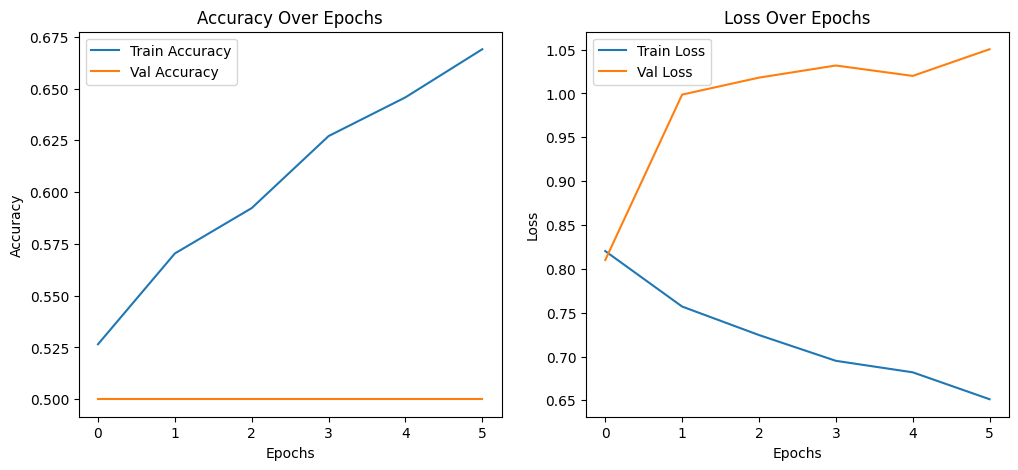

In [ ]:
def plot_history(histories):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(histories.history['accuracy'], label='Train Accuracy')
    plt.plot(histories.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(histories.history['loss'], label='Train Loss')
    plt.plot(histories.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


### Classification Report & Confusion Matrix

20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 622ms/step
              precision    recall  f1-score   support

      NORMAL       0.84      0.82      0.83       234
   PNEUMONIA       0.89      0.91      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624



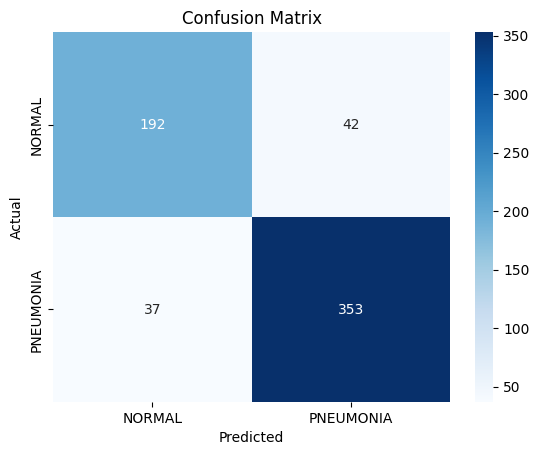

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels and predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

# Report
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## InceptionV3 Model Building & Training

---



### Imports

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Build the Model

Update the train_generator and val_generator image size

In [ ]:
IMG_SIZE = 299

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5293 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Model Architecture

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base layers
base_model.trainable = False

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Define the model
inception_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
inception_model.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Model summary
inception_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 149, 149, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_100   │ (None, 149, 149, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 149, 149, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 147, 147, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_101   │ (None, 147, 147, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 147, 147, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_102   │ (None, 147, 147, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 147, 147, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 73, 73, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_103   │ (None, 73, 73, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 73, 73, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 22,073,889 (84.21 MB)

 Trainable params: 266,753 (1.02 MB)

 Non-trainable params: 21,807,136 (83.19 MB)

### Callbacks

In [ ]:
early_stop_incep = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint_incep = ModelCheckpoint('InceptionV3_Pneumonia.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)


### Train the Model

In [ ]:
history_incep = inception_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop_incep, checkpoint_incep]
)


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7520 - loss: 0.5635
Epoch 1: val_loss improved from inf to 0.37884, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.7523 - loss: 0.5628 - val_accuracy: 0.9375 - val_loss: 0.3788
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.8804 - loss: 0.3234
Epoch 2: val_loss improved from 0.37884 to 0.26887, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 166s 999ms/step - accuracy: 0.8805 - loss: 0.3233 - val_accuracy: 0.8750 - val_loss: 0.2689
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9104 - loss: 0.2510
Epoch 3: val_loss did not improve from 0.26887
166/166 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9104 - loss: 0.2511 - val_accuracy: 0.8750 - val_loss: 0.2776
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9205 - loss: 0.2277
Epoch 4: val_loss improved from 0.26887 to 0.24966, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9205 - loss: 0.2276 - val_accuracy: 0.9375 - val_loss: 0.2497
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9392 - loss: 0.2010
Epoch 5: val_loss improved from 0.24966 to 0.22354, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9392 - loss: 0.2010 - val_accuracy: 0.8750 - val_loss: 0.2235
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9337 - loss: 0.1964
Epoch 6: val_loss did not improve from 0.22354
166/166 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9338 - loss: 0.1963 - val_accuracy: 0.9375 - val_loss: 0.2508
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9420 - loss: 0.1670
Epoch 7: val_loss did not improve from 0.22354
166/166 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9420 - loss: 0.1670 - val_accuracy: 0.9375 - val_loss: 0.2816
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.9543 - loss: 0.1492
Epoch 8: val_loss did not improve from 0.22354
166/166 ━━━━━━━━━━━━━━━━━━━━ 165s 992ms/step - accuracy: 0.9543 - loss: 0.1492 - val_accuracy: 0.9375 - val_loss: 0.2796
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9465 - loss: 0.1552
Epoch 9: val_loss did not improve from 0.

### Fine-Tuning

In [ ]:
base_model.trainable = True

# Compile again with lower learning rate
inception_model.compile(optimizer=Adam(learning_rate=1e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Fine-tune training
fine_tune_incep = inception_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop_incep, checkpoint_incep]
)


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8337 - loss: 0.4077
Epoch 1: val_loss did not improve from 0.22354
166/166 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.8340 - loss: 0.4072 - val_accuracy: 0.7500 - val_loss: 0.6328
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9258 - loss: 0.2262
Epoch 2: val_loss did not improve from 0.22354
166/166 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9258 - loss: 0.2261 - val_accuracy: 0.6875 - val_loss: 1.1624
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9527 - loss: 0.1483
Epoch 3: val_loss did not improve from 0.22354
166/166 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9527 - loss: 0.1483 - val_accuracy: 0.7500 - val_loss: 0.5456
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9523 - loss: 0.1573
Epoch 4: val_loss improved from 0.22354 to 0.18939, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9523 - loss: 0.1572 - val_accuracy: 0.9375 - val_loss: 0.1894
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9683 - loss: 0.1085
Epoch 5: val_loss improved from 0.18939 to 0.16506, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9683 - loss: 0.1085 - val_accuracy: 1.0000 - val_loss: 0.1651
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9678 - loss: 0.1099
Epoch 6: val_loss improved from 0.16506 to 0.11450, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.9678 - loss: 0.1098 - val_accuracy: 1.0000 - val_loss: 0.1145
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9734 - loss: 0.0837
Epoch 7: val_loss improved from 0.11450 to 0.09086, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9734 - loss: 0.0838 - val_accuracy: 1.0000 - val_loss: 0.0909
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9731 - loss: 0.0888
Epoch 8: val_loss improved from 0.09086 to 0.08420, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.9731 - loss: 0.0888 - val_accuracy: 1.0000 - val_loss: 0.0842
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9741 - loss: 0.0811
Epoch 9: val_loss improved from 0.08420 to 0.07930, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9741 - loss: 0.0811 - val_accuracy: 1.0000 - val_loss: 0.0793
Epoch 10/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9789 - loss: 0.0713
Epoch 10: val_loss did not improve from 0.07930
166/166 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9789 - loss: 0.0713 - val_accuracy: 1.0000 - val_loss: 0.0904


### Evaluate on Test Set

In [ ]:
test_loss_incep, test_accuracy_incep = inception_model.evaluate(test_generator)
print(f"InceptionV3 Test Accuracy: {test_accuracy_incep * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 389ms/step - accuracy: 0.8874 - loss: 0.2530
InceptionV3 Test Accuracy: 91.51%


### Plot Training History

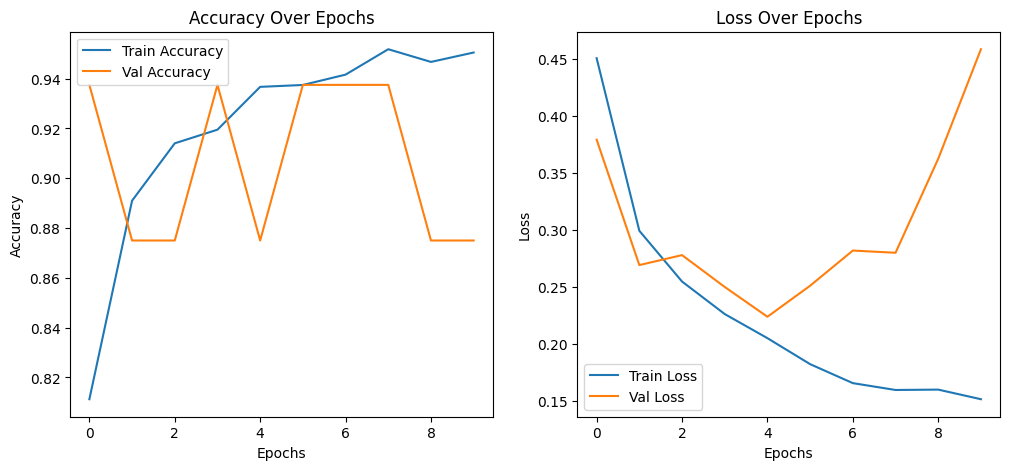

In [ ]:
plot_history(history_incep)


### Classification Report & Confusion Matrix

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 681ms/step
              precision    recall  f1-score   support

      NORMAL       0.92      0.84      0.88       234
   PNEUMONIA       0.91      0.96      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624



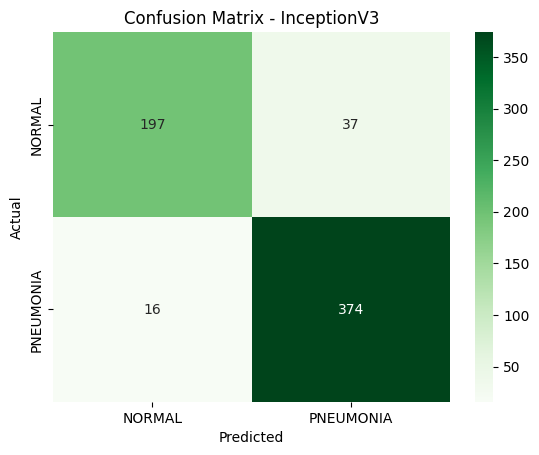

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_true_incep = test_generator.classes
y_pred_probs_incep = inception_model.predict(test_generator)
y_pred_incep = (y_pred_probs_incep > 0.5).astype(int)

# Report
print(classification_report(y_true_incep, y_pred_incep, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion Matrix
cm_incep = confusion_matrix(y_true_incep, y_pred_incep)
sns.heatmap(cm_incep, annot=True, fmt='d', cmap='Greens', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - InceptionV3')
plt.show()


## Grad-CAM Function (InceptionV3)

---



In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = array / 255.0
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


### Run Grad-CAM On Images (InceptionV3)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1290']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


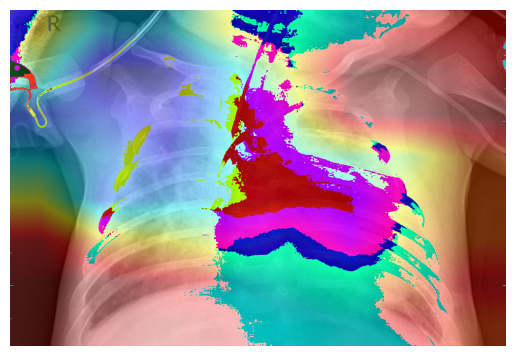

In [ ]:
# Example paths (replace with actual paths in your drive)
img_path_normal = '/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0005-0001.jpeg'
img_path_pneumonia = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'

# Preprocess image
img_array = get_img_array(img_path_pneumonia, size=(299, 299))

# Get Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, inception_model, last_conv_layer_name='mixed10')  # Last conv layer in InceptionV3

# Display Grad-CAM
display_gradcam(img_path_pneumonia, heatmap)
